# Isprobavanje multi label classifiera sa efficient netom



In [2]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=41254f416861281edf75f88c959108cc0324d398d85323ad2edc68de930208cd
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision.io import read_image
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

import time
from datetime import datetime

from efficientnet_pytorch import EfficientNet

plt.ion()   # interactive mode

In [4]:
# Access to uploaded files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir_prefix = 'drive/My Drive/Colab Notebooks/Diplomski'
values = ['no', 'yes']

In [6]:
class MultiLabelToothDataset(Dataset):
  def __init__(self, csv_file, img_dir, transform=None, target_transform=None, subset=None):
    self.subset = subset
    self.df = pd.read_csv(csv_file, sep = ";")
    if self.subset: self.df = self.subset(self.df)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
    self.ret_indx = False

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
    img_path = os.path.join(self.img_dir, img_name)
    image = Image.open(img_path)
    #image = read_image(img_path)
    label = row
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    if self.ret_indx: return image, label, torch.tensor(idx)    
    return image, label

class MultiLabelToTensor(object):
  def __init__(self, attrs_of_interest):
    self.attrs_of_interest = attrs_of_interest
  
  def __call__(self, row):
    return torch.tensor([1.0 if row[x] == 'yes' else 0.0 for x in self.attrs_of_interest])

In [7]:
def keep_only_subset(df, num_of_total_negatives=-1, num_of_positives=-1):
  df_some_yes = df[~((df['crown'] == 'no') & (df['endofilling'] == 'no') & (df['filling'] == 'no') & (df['bridge'] == 'no'))]
  df_all_no = df[(df['crown'] == 'no') & (df['endofilling'] == 'no') & (df['filling'] == 'no') & (df['bridge'] == 'no')]
  if num_of_total_negatives >= 0:
    df_all_no = df_all_no.sample(n=num_of_total_negatives, random_state=1)
  if num_of_positives >= 0:
    df_some_yes = df_some_yes.sample(n=num_of_positives, random_state=1)
  print(f'len(df_some_yes): {len(df_some_yes)}, len(df_all_no): {len(df_all_no)}')
  return pd.concat([df_some_yes,df_all_no]).copy()

In [8]:
attrs_of_interest = ['bridge', 'endofilling', 'filling', 'crown']
img_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
image_datasets = dict()
dataloaders = dict()
dataset_sizes = dict()
class_names = dict()

csv_filename = os.path.join(dir_prefix, 'multi_label_dataset/tooth_info.csv')
img_dir = os.path.join(dir_prefix, 'multi_label_dataset/img')
dataset = MultiLabelToothDataset(csv_filename, 
                                 img_dir,
                                 transform=img_transforms,
                                 target_transform=MultiLabelToTensor(attrs_of_interest),
                                 subset=lambda df: keep_only_subset(df, num_of_total_negatives=9000)
                                )
total_number = len(dataset)
split_size = [int(total_number * 0.7), total_number - int(total_number * 0.7)]
dataset_train, dataset_val = random_split(dataset, split_size, generator=torch.Generator().manual_seed(42))

image_datasets = {'train': dataset_train, 'val': dataset_val}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = attrs_of_interest

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

len(df_some_yes): 8790, len(df_all_no): 9000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
print(class_names)
df_sub = dataset.df
ratio = {x: len(df_sub[df_sub[x] == 'no'])/len(df_sub[df_sub[x] == 'yes']) for x in attrs_of_interest}
print(ratio)
pos_weight = torch.tensor([ratio[x] for x in attrs_of_interest])
pos_weight = pos_weight.to(device)
print(pos_weight)

['bridge', 'endofilling', 'filling', 'crown']
{'bridge': 33.81409001956947, 'endofilling': 8.44267515923567, 'filling': 1.6215738284703802, 'crown': 11.475455820476858}
tensor([33.8141,  8.4427,  1.6216, 11.4755], device='cuda:0')


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[[f'{class_names[i]}-{values[int(x)]}' for i,x in enumerate(labels)] for labels in classes])



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
def train_model(model, criterion, optimizer, scheduler, THRES, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds =  (torch.sigmoid(outputs) > THRES)* 1.0

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / (dataset_sizes[phase] * len(attrs_of_interest))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, THRES, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > THRES)* 1.0

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, truth: {}'.format([f'{class_names[i]}-{values[int(x)]}' for i,x in enumerate(preds[j])], [f'{class_names[i]}-{values[int(x)]}' for i,x in enumerate(labels.data[j])]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [11]:
#model_ft = models.resnet18(pretrained=True)
#efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to NUM_CLASSES=n.
NUM_CLASSES=4
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
efficientnet._fc= torch.nn.Linear(in_features=efficientnet._fc.in_features, out_features=NUM_CLASSES, bias=True)
model_ft = efficientnet
#num_ftrs = model_ft.fc.in_features



model_ft = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [12]:
num_epochs=15
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       THRES=0.5, num_epochs=num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6090 Acc: 0.8189
val Loss: 0.5564 Acc: 0.8712

Epoch 1/14
----------
train Loss: 0.3457 Acc: 0.9021
val Loss: 0.2911 Acc: 0.9070

Epoch 2/14
----------
train Loss: 0.2578 Acc: 0.9283
val Loss: 0.2089 Acc: 0.9496

Epoch 3/14
----------
train Loss: 0.2196 Acc: 0.9384
val Loss: 0.2146 Acc: 0.9465

Epoch 4/14
----------
train Loss: 0.1892 Acc: 0.9480
val Loss: 0.1990 Acc: 0.9516

Epoch 5/14
----------
train Loss: 0.1724 Acc: 0.9515
val Loss: 0.2147 Acc: 0.9581

Epoch 6/14
----------
train Loss: 0.1489 Acc: 0.9585
val Loss: 0.1992 Acc: 0.9587

Epoch 7/14
----------
train Loss: 0.1306 Acc: 0.9640
val Loss: 0.2069 Acc: 0.9617

Epoch 8/14
----------
train Loss: 0.1291 Acc: 0.9655
val Loss: 0.2023 Acc: 0.9607

Epoch 9/14
----------
train Loss: 0.1239 Acc: 0.9658
val Loss: 0.2043 Acc: 0.9602

Epoch 10/14
----------
train Loss: 0.1245 Acc: 0.9659
val Loss: 0.2036 Acc: 0.9612

Epoch 11/14
----------
train Loss: 0.1207 Acc: 0.9663
val Loss: 0.2066 Acc: 0.9614

Epoch 12/14
----------
t

In [13]:
# datetime object containing current date and time
now = datetime.now()
 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

torch.save(model_ft, os.path.join(dir_prefix, f'models/efficientnet-multilabel_model-{dt_string}-epochs-{num_epochs}'))

In [10]:
# Load the model 

model = torch.load(os.path.join(dir_prefix, 'models/efficientnet-multilabel_model-01:02:2022-21:30:29-epochs-15'))
model.eval()
model_ft = model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


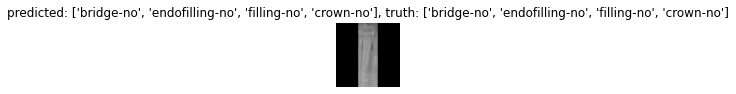

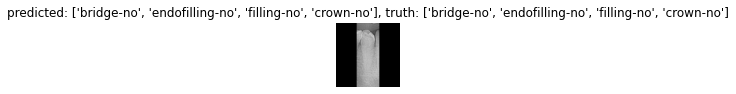

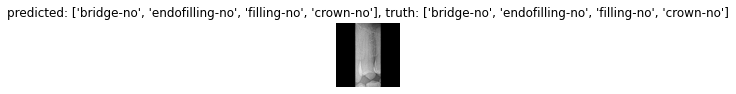

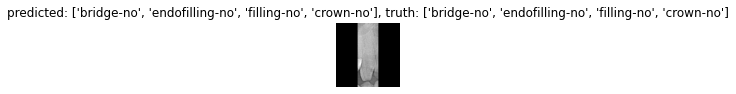

In [ ]:
visualize_model(model_ft, THRES=0.5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: 

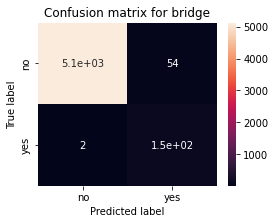

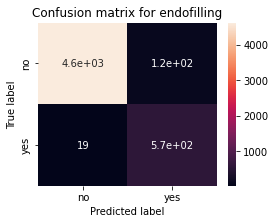

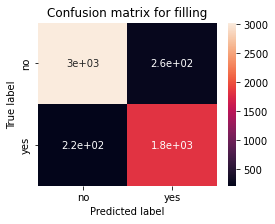

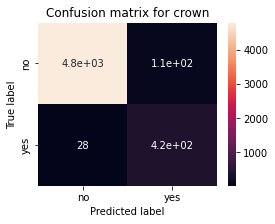

In [15]:
for i,attr in enumerate(attrs_of_interest):
  y_pred = []
  y_true = []

  was_training = model_ft.training
  model_ft.eval()

  with torch.no_grad():
  # iterate over test data
    for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model_ft(inputs)
      preds =  (torch.sigmoid(outputs) > .5) * 1.0

      outputs = (preds[:, i]).data.cpu().numpy()
      y_pred.extend(outputs) # Save Prediction
      
      labels = (labels[:, i]).data.cpu().numpy()
      y_true.extend(labels) # Save Truth
  
  model_ft.train(mode=was_training)

  # constant for classes
  classes = ('no', 'yes')

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  # Columns (True labels) sum to 100%
  # df_cm = pd.DataFrame(cf_matrix / np.reshape(np.sum(cf_matrix, axis=0), (1,2)), index = [i for i in classes],
  #                     columns = [i for i in classes])
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                    columns = [i for i in classes])
  plt.figure(figsize = (4,3))
  sn.heatmap(df_cm, annot=True)
  plt.title(f'Confusion matrix for {attr}')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')

  # datetime object containing current date and time
  now = datetime.now()
  # dd/mm/YY H:M:S
  dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

  plt.savefig(f'{dir_prefix}/graphics/efficientNet/efficient-net-multilabel_model-{attr}-confusion_matrix-{dt_string}.png', dpi=1000)

In [11]:
dataset.ret_indx = True
dataset_train, dataset_val2 = random_split(dataset, split_size, generator=torch.Generator().manual_seed(42))

dataloader_last = torch.utils.data.DataLoader(dataset_val2, batch_size=1, shuffle=False, num_workers=4)

y_pred_right = []
y_pred = []
y_true = []
val_indxs = []
i = 0
for inputs, labels, indx in dataloader_last:
  inputs = inputs.to(device)
  labels = labels.to(device)
  val_indxs.append(int(indx))
  outputs = model_ft(inputs)
  preds =  (torch.sigmoid(outputs) > .5) * 1.0

  outputs = (preds).data.cpu().numpy()
  y_pred.extend(outputs)
  y_true.extend((labels).data.cpu().numpy())
  # if i == 10: break
  # i += 1

y_pred_right = np.array(y_pred_right)
y_pred = np.array(y_pred)
y_true = np.array(y_true)

anal_df = dataset.df.iloc[val_indxs].copy()


for i, c in enumerate(class_names):
  anal_df[f'predicted-{c}'] = y_pred[:, i]
  anal_df[f'true-{c}'] = y_true[:, i]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
def rows_where_mismatch(df, at):
  return df[df[f'predicted-{at}'] != df[f'true-{at}']]

def just_tooth(df, quad, index):
  return df[(df['quad'] == int(quad)) & (df['index'] == int(index))]


print(anal_df.columns)
w_fill = rows_where_mismatch(anal_df, 'filling')

print(w_fill.head())
print(len(w_fill))

Index(['image_identifier', 'image_md5', 'id_hash', 'age', 'sex', 'quad',
       'index', 'status_shorthand', 'x1', 'y1', 'x2', 'y2', 'missing', 'germ',
       'root', 'implant', 'bridge', 'endofilling', 'filling', 'crown',
       'tooth_decay', 'appliance', 'img_name', 'tooth_id', 'center_x',
       'center_y', 'width', 'height', 'predicted-bridge', 'true-bridge',
       'predicted-endofilling', 'true-endofilling', 'predicted-filling',
       'true-filling', 'predicted-crown', 'true-crown'],
      dtype='object')
                                        image_identifier  ... true-crown
20194        smooth-political-shiny-murky-magnificent-go  ...        0.0
10010       knowing-learned-elastic-educated-jolly-claim  ...        0.0
24141   hospitable-glib-regular-windy-boundless-teaching  ...        0.0
25014         ad hoc-cautious-hungry-vigorous-level-hate  ...        0.0
24882  abhorrent-stale-reminiscent-lame-synonymous-in...  ...        1.0

[5 rows x 36 columns]
480


In [13]:
sus_teeth = [(1, 4), (3, 7), (1, 3), (4, 6), (2, 1), (2, 2), (2, 7), (3, 6)]
for sus_tooth in sus_teeth:
  print(f'Tooth: {sus_tooth[0]}-{sus_tooth[1]}')
  curr_w_fill = just_tooth(w_fill, quad=sus_tooth[0], index=sus_tooth[1])
  fp = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 1) & (curr_w_fill['true-filling'] == 0)])
  fn = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 0) & (curr_w_fill['true-filling'] == 1)])
  fp_explained_by_endofilling = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 1) & (curr_w_fill['predicted-endofilling'] == 1) & (curr_w_fill['true-endofilling'] == 1)])
  fn_explained_by_endofilling = len(curr_w_fill[(curr_w_fill['predicted-filling'] == 0) & (curr_w_fill['predicted-endofilling'] == 1)])
  print(f'fp_explained_by_endofilling: {fp_explained_by_endofilling}/{fp}')
  print(f'fn_explained_by_endofilling: {fn_explained_by_endofilling}/{fn}')
  print()

Tooth: 1-4
fp_explained_by_endofilling: 5/16
fn_explained_by_endofilling: 5/11

Tooth: 3-7
fp_explained_by_endofilling: 1/15
fn_explained_by_endofilling: 1/16

Tooth: 1-3
fp_explained_by_endofilling: 3/14
fn_explained_by_endofilling: 0/6

Tooth: 4-6
fp_explained_by_endofilling: 7/20
fn_explained_by_endofilling: 2/7

Tooth: 2-1
fp_explained_by_endofilling: 0/10
fn_explained_by_endofilling: 2/12

Tooth: 2-2
fp_explained_by_endofilling: 0/9
fn_explained_by_endofilling: 1/11

Tooth: 2-7
fp_explained_by_endofilling: 3/13
fn_explained_by_endofilling: 4/12

Tooth: 3-6
fp_explained_by_endofilling: 7/18
fn_explained_by_endofilling: 0/5



Images of teeth: 1-4
true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


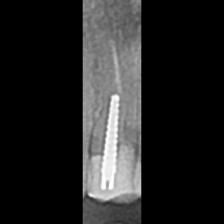


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


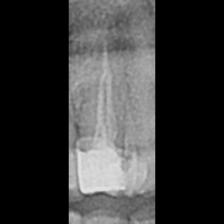


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


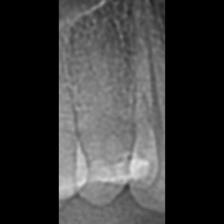


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


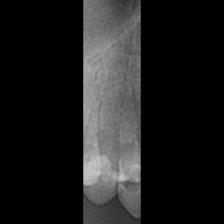


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


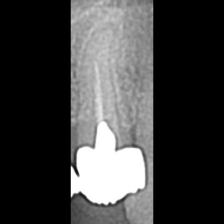


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


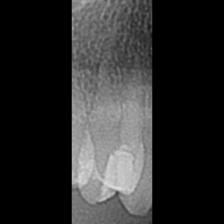


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


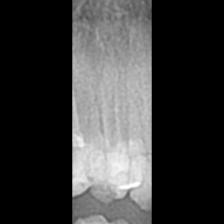


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


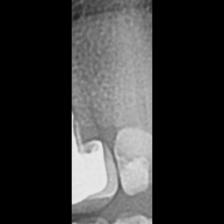


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


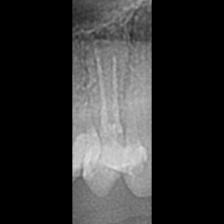


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


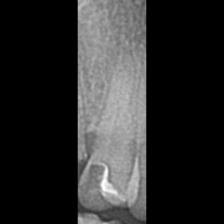


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


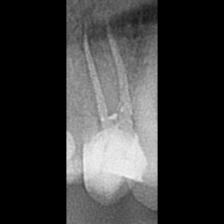


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


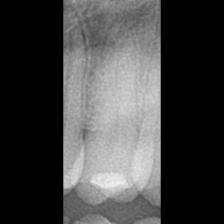


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


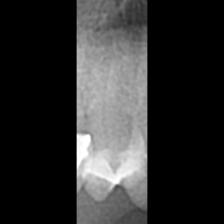


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


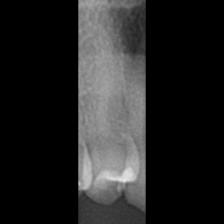


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


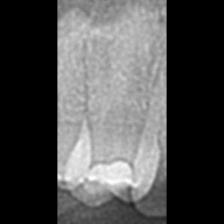


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


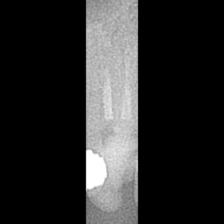


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


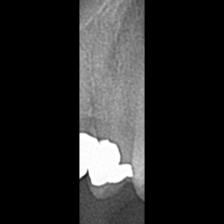


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


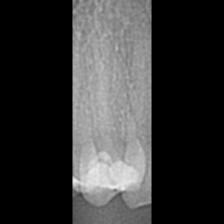


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


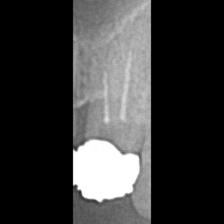


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


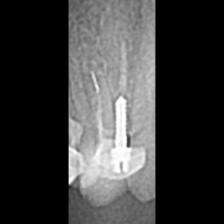


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


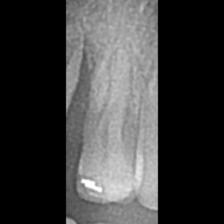


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


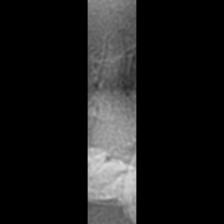


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


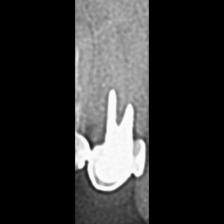


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


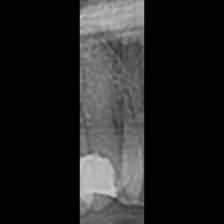





Images of teeth: 3-7
true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


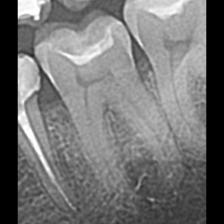


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


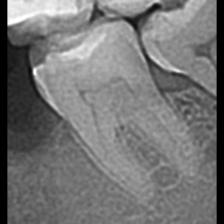


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


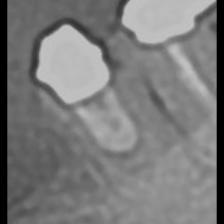


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


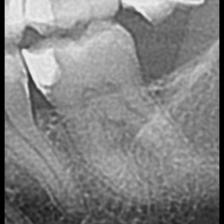


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


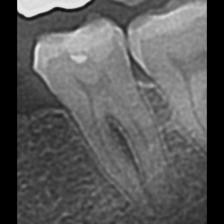


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


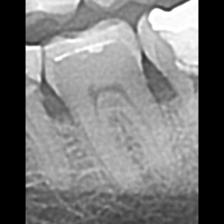


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


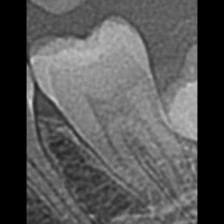


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


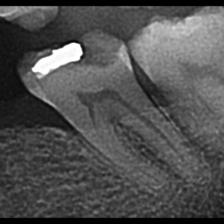


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


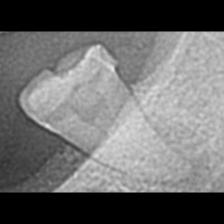


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


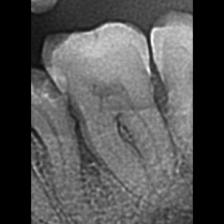


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


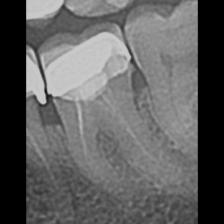


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


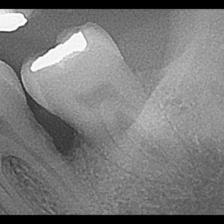


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


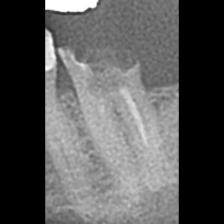


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


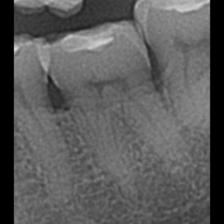


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


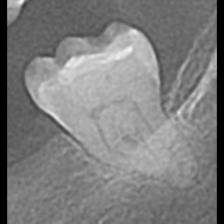


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


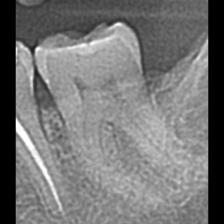


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


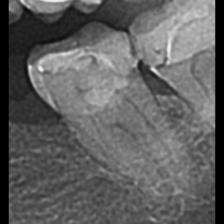


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


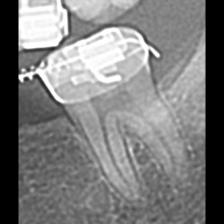


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


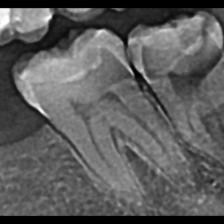


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


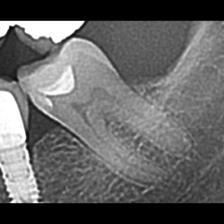


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


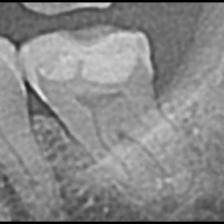


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


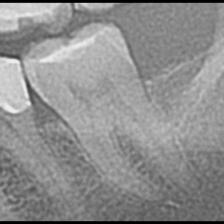


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


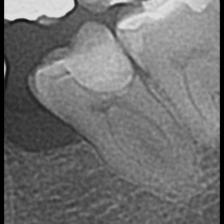


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


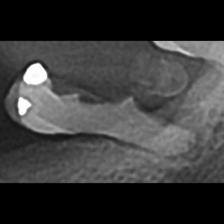


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


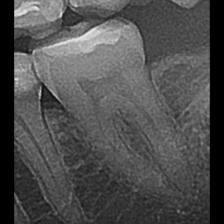


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


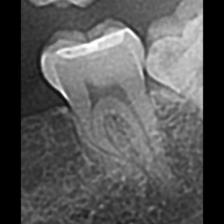


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


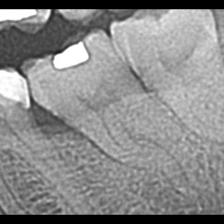


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


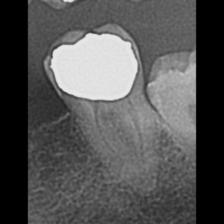


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


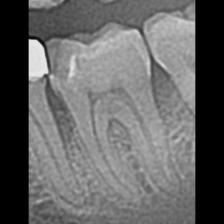


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


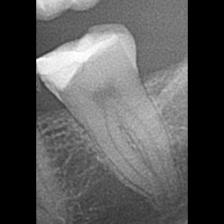





Images of teeth: 1-3
true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


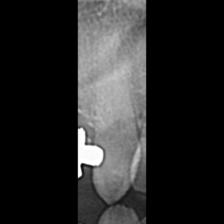


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


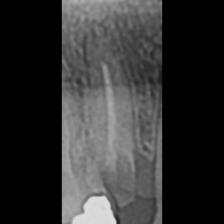


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


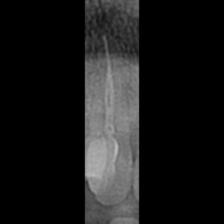


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


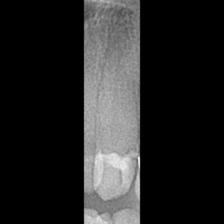


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


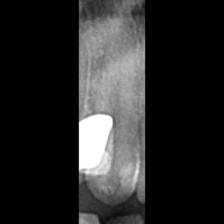


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


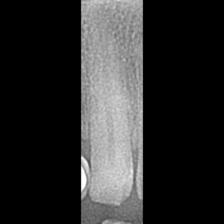


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


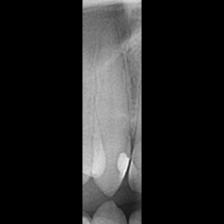


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


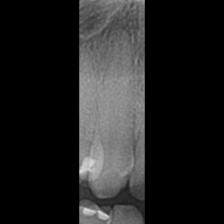


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


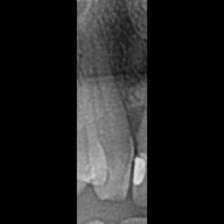


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


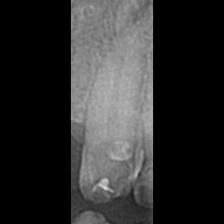


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


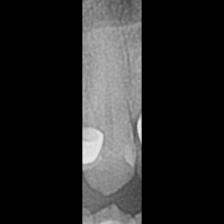


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


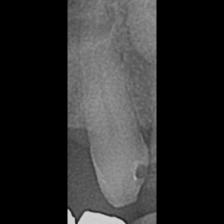


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


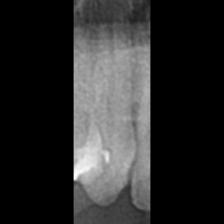


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


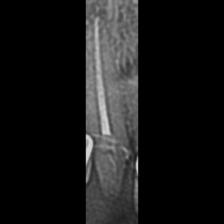


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


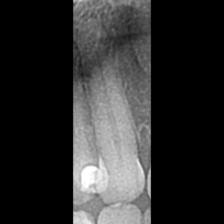





Images of teeth: 4-6
true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


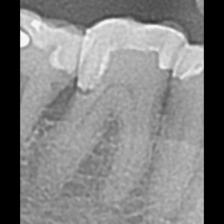


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


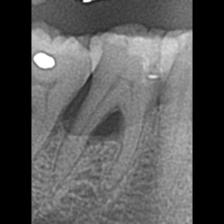


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


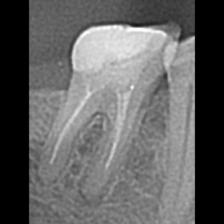


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


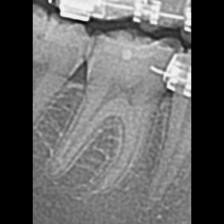


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


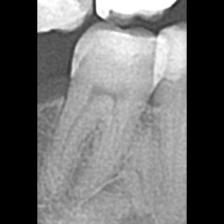


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


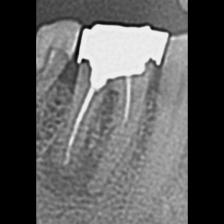


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


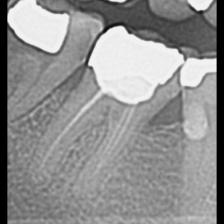


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


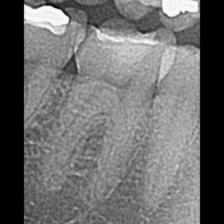


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


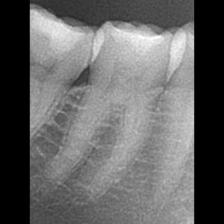


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


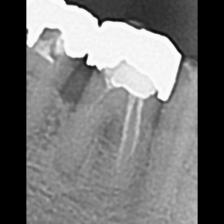


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 1.0, true-bridge: 0.0


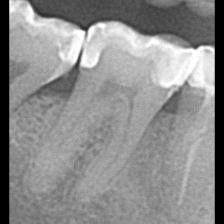


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


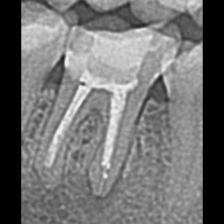


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


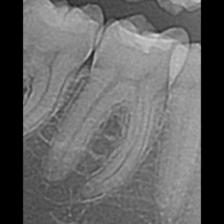


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


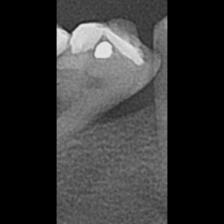


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


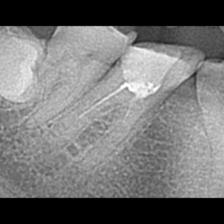


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


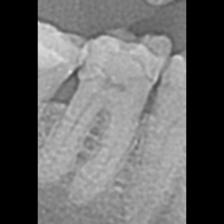


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0






Images of teeth: 2-1
true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


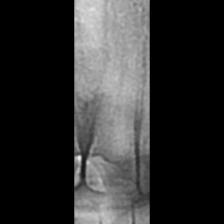


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


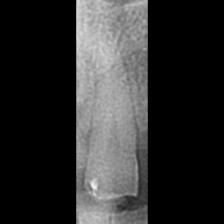


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


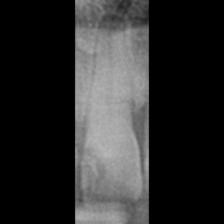


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


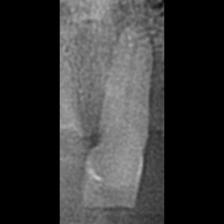


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


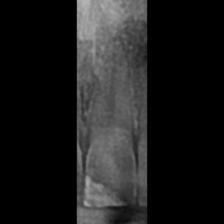


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


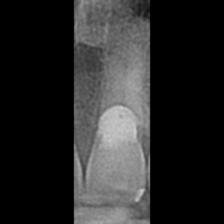


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


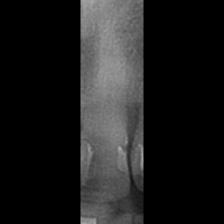


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


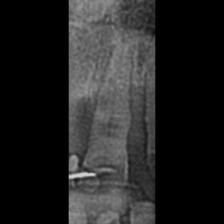


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


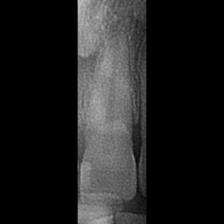


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


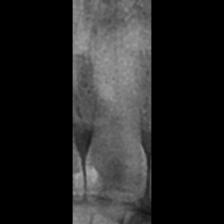


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


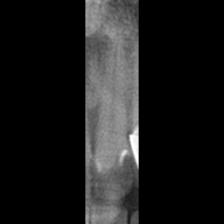


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


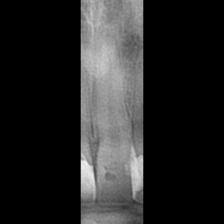


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


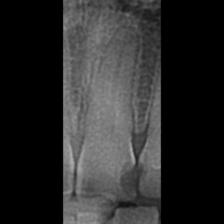


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


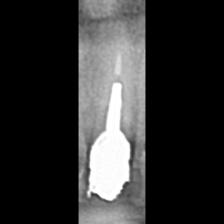


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


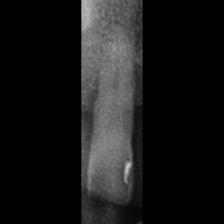


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


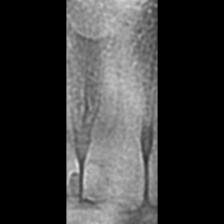





Images of teeth: 2-2
true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


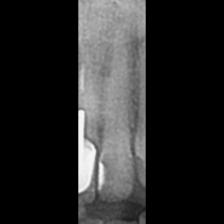


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


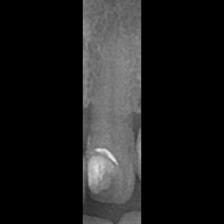


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


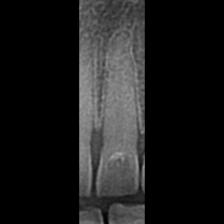


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


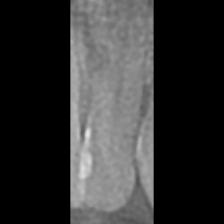


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


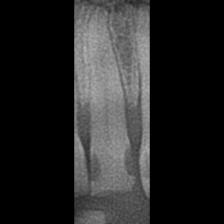


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


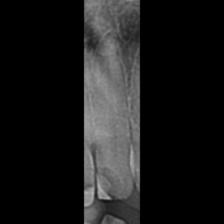


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


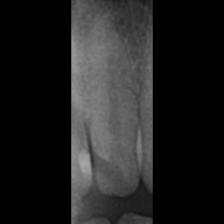


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 1.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


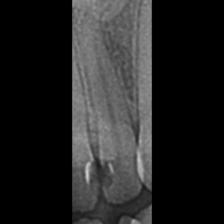


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


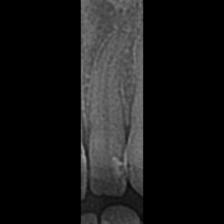


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


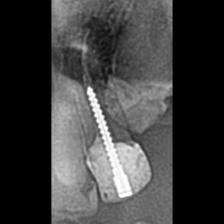


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


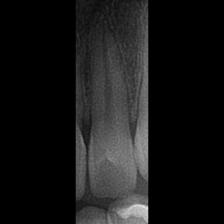


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


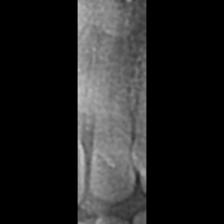


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


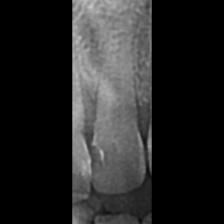





Images of teeth: 2-7
true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


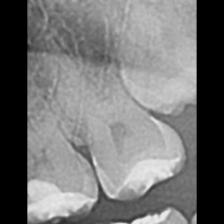


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


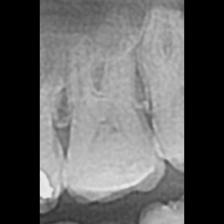


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


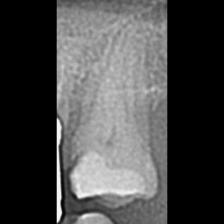


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


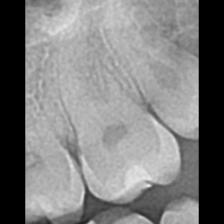


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


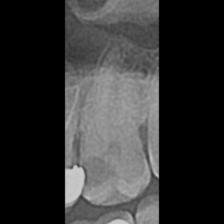


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


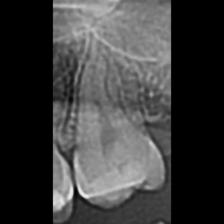


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


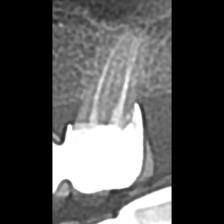


true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


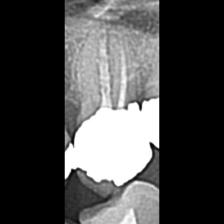


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 1.0, predicted-filling: 0.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


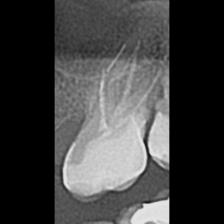


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


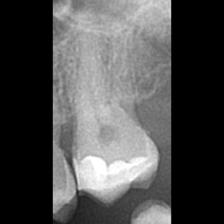


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


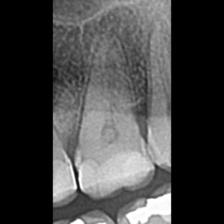


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


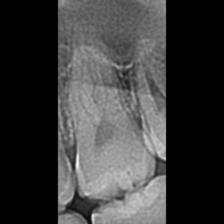


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


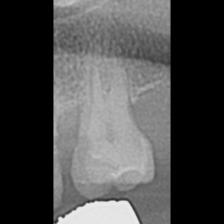


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


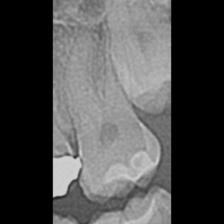


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


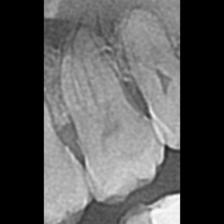


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


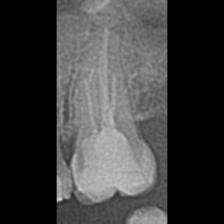


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


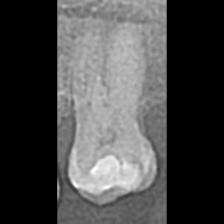





Images of teeth: 3-6
true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


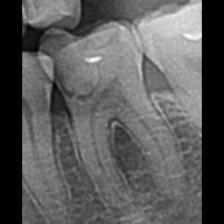


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


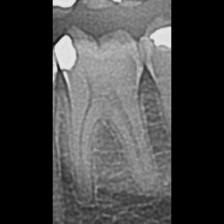


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


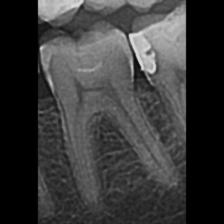


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0


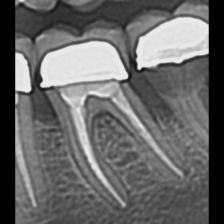


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 1.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


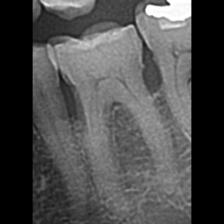


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


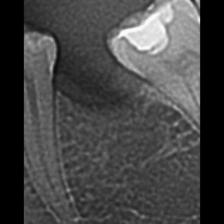


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


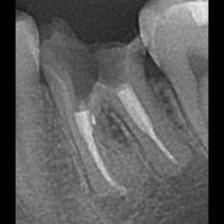


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 0.0, true-bridge: 0.0


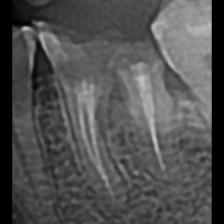


true-filling: 0.0, true-endofilling: 1.0, predicted-filling: 1.0, predicted-endofilling: 1.0,
 true-crown: 1.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


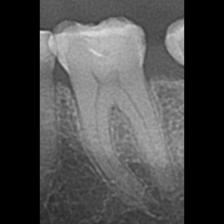


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


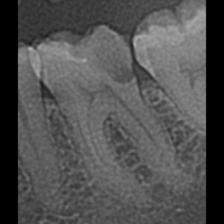


true-filling: 1.0, true-endofilling: 0.0, predicted-filling: 0.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0



true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


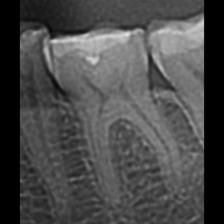


true-filling: 0.0, true-endofilling: 0.0, predicted-filling: 1.0, predicted-endofilling: 0.0,
 true-crown: 0.0, true-bridge: 0.0


In [14]:
img_dir = os.path.join(dir_prefix, 'multi_label_dataset/img')
for sus_tooth in sus_teeth:
  print(f'Images of teeth: {sus_tooth[0]}-{sus_tooth[1]}')
  curr_w_fill = just_tooth(w_fill, quad=sus_tooth[0], index=sus_tooth[1])
  for idx_row in curr_w_fill.iterrows():
    row = idx_row[1]
    img_name = row['image_identifier'] + "_" + row['image_md5'] + '--' + row['tooth_id'] + '.jpg'
    img_path = os.path.join(img_dir, img_name)
    image = Image.open(img_path)
    print(f"true-filling: {row['true-filling']}, true-endofilling: {row['true-endofilling']}, predicted-filling: {row['predicted-filling']}, predicted-endofilling: {row['predicted-endofilling']},\n true-crown: {row['true-crown']}, true-bridge: {row['true-bridge']}")
    display(image)
    print()
  print()
  print()
  print()

quad  index  true-bridge  predicted-bridge
2     7      0.0          0.0                 215
      6      0.0          0.0                 215
3     7      0.0          0.0                 207
1     7      0.0          0.0                 206
4     6      0.0          0.0                 205
                                             ... 
      2      1.0          1.0                   1
1     1      0.0          1.0                   1
3     1      0.0          1.0                   1
      8      0.0          1.0                   1
5     5      0.0          0.0                   1
Length: 82, dtype: int64
quad  index  true-endofilling  predicted-endofilling
3     7      0.0               0.0                      185
2     6      0.0               0.0                      184
      7      0.0               0.0                      183
1     7      0.0               0.0                      175
3     6      0.0               0.0                      168
                             

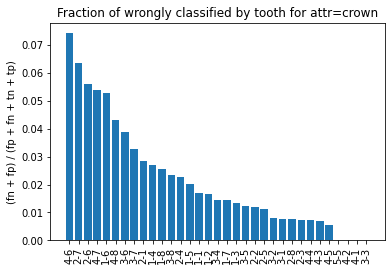

In [18]:
for attr in attrs_of_interest:
  select = ['quad', 'index', f'true-{attr}', f'predicted-{attr}']
  cf_matrices = dict()             # first key => quad, second key => index, then 2d confusion array
  print(anal_df[select].value_counts())
  for val, cnt in anal_df[select].value_counts().iteritems():
    if not val[0] in cf_matrices: cf_matrices[val[0]] = dict()
    if not val[1] in cf_matrices[val[0]]: cf_matrices[val[0]][val[1]] = np.zeros((2,2))

    cf_matrices[val[0]][val[1]][int(val[2])][int(val[3])] = cnt
  
  classes = ('no', 'yes')
  l = []
  for quad in cf_matrices:
    for index in cf_matrices[quad]:
      if None:
        df_cm = pd.DataFrame(cf_matrices[quad][index], index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (4,3))
        sn.heatmap(df_cm, annot=True)
        plt.title(f'Confusion matrix for {attr}, teeth-id: {quad}-{index}')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # datetime object containing current date and time
        now = datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

        plt.savefig(f'{dir_prefix}/graphics/efficientNet/confusion_matrices/multilabel_model-{attr}-cm-{dt_string}-{quad}-{index}.png', dpi=1000)

      mat = cf_matrices[quad][index]
      l.append(((mat[0][1] + mat[1][0]) / mat.sum(), f'{quad}-{index}'))
  l.sort(reverse=True)
  x = [i[1] for i in l]
  y = [i[0] for i in l]
  plt.figure()
  plt.bar(x, y)
  plt.title(f'Fraction of wrongly classified by tooth for attr={attr}')
  plt.ylabel('(fn + fp) / (fp + fn + tn + tp)')
  plt.xticks(rotation = 90)
  # datetime object containing current date and time
  now = datetime.now()
  # dd/mm/YY H:M:S
  dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")
  plt.savefig(f'{dir_prefix}/graphics/efficientNet/barGraphs/bargrpah-{attr}-{dt_string}.png', dpi=1000)
  # plt.show()



age-int  true-bridge  predicted-bridge
43       0.0          0.0                 138
47       0.0          0.0                 137
42       0.0          0.0                 130
39       0.0          0.0                 127
30       0.0          0.0                 121
                                         ... 
70       0.0          1.0                   1
60       0.0          1.0                   1
68       0.0          1.0                   1
65       0.0          1.0                   1
36       1.0          1.0                   1
Length: 141, dtype: int64
age-int  true-endofilling  predicted-endofilling
43       0.0               0.0                      122
47       0.0               0.0                      120
39       0.0               0.0                      119
33       0.0               0.0                      116
30       0.0               0.0                      112
                                                   ... 
71       1.0               0.0              

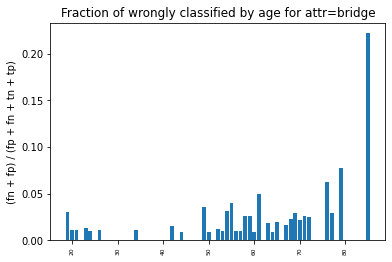

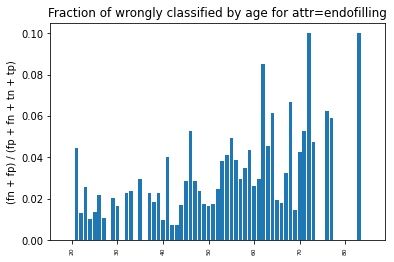

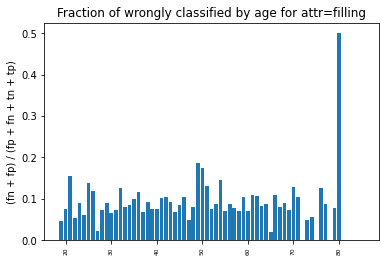

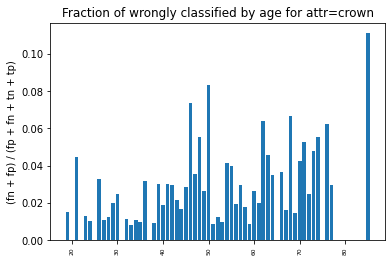

In [19]:
anal_df['age-int'] = anal_df['age'].astype(int)
for attr in attrs_of_interest:
  select = ['age-int', f'true-{attr}', f'predicted-{attr}']
  cf_matrices = dict()             # first key => quad, second key => index, then 2d confusion array
  print(anal_df[select].value_counts())
  for val, cnt in anal_df[select].value_counts().iteritems():
    if not val[0] in cf_matrices: cf_matrices[val[0]] = np.zeros((2,2))

    cf_matrices[val[0]][int(val[1])][int(val[2])] = cnt
  
  classes = ('no', 'yes')
  l = []
  for age in cf_matrices:
      if None:
        df_cm = pd.DataFrame(cf_matrices[age], index = [i for i in classes],
                        columns = [i for i in classes])
        plt.figure(figsize = (4,3))
        sn.heatmap(df_cm, annot=True)
        plt.title(f'Confusion matrix for {attr}, age: {age}')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # datetime object containing current date and time
        now = datetime.now()
        # dd/mm/YY H:M:S
        dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")

        plt.savefig(f'{dir_prefix}/graphics/efficientNet/cm-age/multilabel_model-{attr}-confusion_matrix-{dt_string}-{age}.png', dpi=1000)

      mat = cf_matrices[age]
      l.append((age, (mat[0][1] + mat[1][0]) / mat.sum()))
  l.sort()
  x = [i[0] for i in l]
  y = [i[1] for i in l]
  plt.figure()
  plt.bar(x, y)
  plt.title(f'Fraction of wrongly classified by age for attr={attr}')
  plt.ylabel('(fn + fp) / (fp + fn + tn + tp)')
  plt.xticks(fontsize=6, rotation = 90)
  # datetime object containing current date and time
  now = datetime.now()
  # dd/mm/YY H:M:S
  dt_string = now.strftime("%d:%m:%Y-%H:%M:%S")
  plt.savefig(f'{dir_prefix}/graphics/efficientNet/age-barGraphs/bargrpah-{attr}-{dt_string}.png', dpi=1000)
  # plt.show()